In [1]:
import pandas_datareader as pdr
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS
import pandas as pd
import numpy as np
import datetime
import requests_cache

expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

In [2]:
class Fund:

    def __init__(self, tickers, inception_date, weights = 'eq', rebalancing = False, fund_size = 1000000, end_date = datetime.datetime.today()):
        self.tickers = tickers
        self.start = inception_date
        self.end = pd.to_datetime(end_date)-pd.offsets.BDay()
        self.rebalancing = (False if not rebalancing else 'B' + rebalancing) # options 'Q', 'A'
        self.size = fund_size
        self.weights = self.calc_weights(weights)
        self.prices = self.get_data(self.tickers)
        self.holdings = self.calc_holdings()
        self.values = self.holdings * self.prices
        self.nav = self.values.sum(axis=1)
    
    def get_data(self, tickers):
        df = pdr.yahoo.daily.YahooDailyReader(
        symbols=tickers,
        start=self.start,
        end=self.end,
        retry_count=3,
        pause=0.1,
        session=session,
        adjust_price=False,
        ret_index=False,
        chunksize=25,
        interval='d',
        get_actions=False,
        adjust_dividends=True).read()['Adj Close']

        df.index = pd.to_datetime(df.index)
        return df.asfreq('B', method='ffill')

    def calc_weights(self, weights):
        if type(weights) == str:
            if weights == 'eq':
                return np.ones(len(self.tickers)) * (1/len(self.tickers))
            elif weights == 'mkt':
                raise NotImplementedError()
        else:
            return np.array(weights)

    @staticmethod
    def calc_shares(prices, weights, fund_size):
            return pd.DataFrame(weights*fund_size/prices).round().transpose()

    def calc_holdings(self):
        holdings = self.calc_shares(self.prices.iloc[0], self.weights, self.size)

        if self.rebalancing != False:
            dates = pd.date_range(start=self.start, end=self.end, freq=self.rebalancing)
            for i in range(dates.size):
                date = dates[i]
                fund_size = (holdings.iloc[i]*self.prices.loc[date-pd.offsets.BDay()]).sum()
                holdings = holdings.append(self.calc_shares(self.prices.loc[date], self.weights, fund_size))

        holdings = holdings.append(pd.DataFrame([holdings.iloc[-1].values], columns=holdings.columns, index=pd.DatetimeIndex([self.end])))
        return holdings.asfreq('B', method='ffill')

    def benchmark(self, ticker):
        bench = self.get_data(ticker)
        return pd.concat({
            'Fund': self.nav/self.nav[0]-1,
            ticker: (bench/bench[0]-1),
        }, axis=1)


In [3]:
start = datetime.datetime(2020, 1, 2)
end = datetime.datetime.today()
tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'GOOG', 'TSLA', 'NVDA', 'BRK-B', 'JPM']
weights = np.array([0.15, 0.1, 0.1, 0.1, 0.05, 0.05, 0.1, 0.15, 0.1, 0.1])
rebalancing = 'Q'
fund_size = 100000

test = Fund(tickers, start, weights, rebalancing, fund_size, end)

<AxesSubplot:>

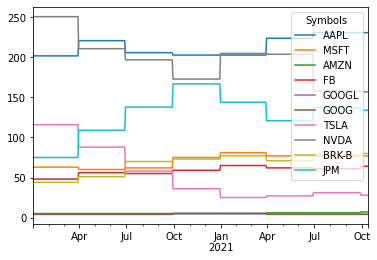

In [4]:
test.holdings.plot()

<AxesSubplot:>

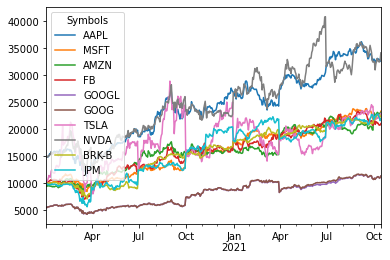

In [5]:
test.values.plot()

<AxesSubplot:>

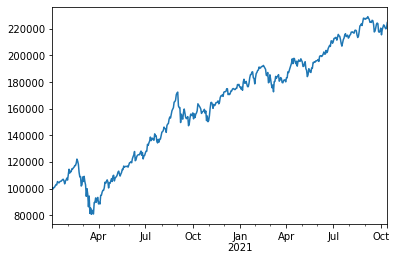

In [6]:
test.nav.plot()

<AxesSubplot:>

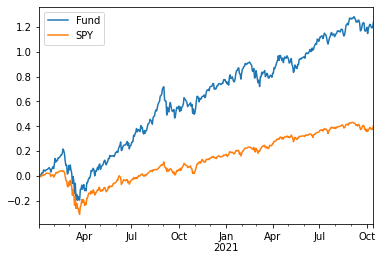

In [7]:
test.benchmark('SPY').plot()